In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression 
from  sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix


# Import Data

In [3]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
gs=pd.read_csv("gender_submission.csv")

I like to look at the _tail_, rather than the _head_, of a df, since it gives you the number of instances as well as a peak at the data

# Initial analysis

## Data structure

In [115]:
train.tail(2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [560]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [561]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The train data set has missing values. In particular, the cabin data is particularly sparse.

In [562]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

So _Age_, _Cabin_, and _Embarked_ features have missing instances. How many rows have missing data?

In [563]:
train.shape[0]-train.dropna().shape[0]

708

We want to model survival or fatality by building a binary classifier. How many people died on the titanic in our train set?

In [7]:
train.loc[train["Survived"]==0].shape[0]

549

In [8]:
print("Died {} ({:.0f}%)\nSurvived: {} ({:.0f}%)".format(len(train[train["Survived"]==0]),
                                                (len(train[train["Survived"]==0])/len(train))*100,
                                                len(train[train["Survived"]==1]),
                                               (len(train[train["Survived"]==1])/len(train))*100))


Died 549 (62%)
Survived: 342 (38%)


## Pair Plot

Our train set is biased by 2:1 for deaths vs survival. Lets do a pairwise plot using only rows with full instances with no NAs, and only numeric values

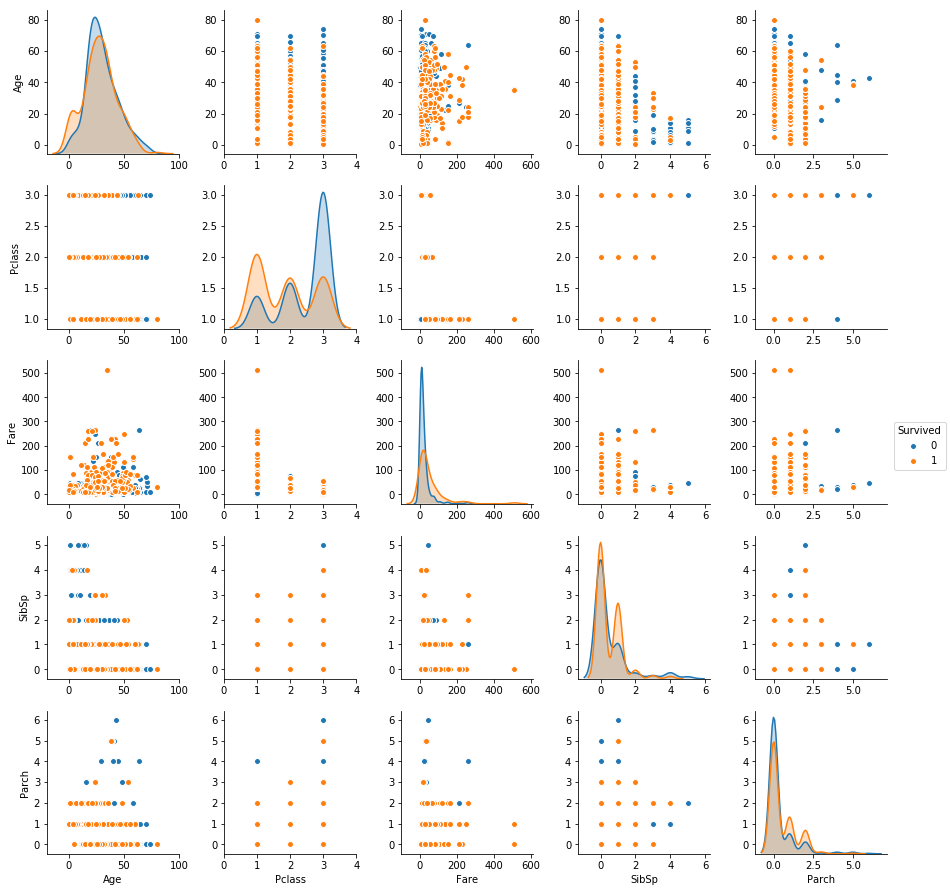

In [664]:
sns.pairplot(train.dropna(),hue="Survived",vars=["Age","Pclass","Fare","SibSp","Parch"],diag_kind="kde",diag_kws=dict(shade=True))

## Features

### Gender

In [566]:
def bar_by_feat(dataframe,feat1,feat2):
    """Plot two feature 1 against feature 2 of the data frame"""
    positive=dataframe[dataframe[feat1]==1][feat2].value_counts()
    negative=dataframe[dataframe[feat1]==0][feat2].value_counts()
    newdf=pd.DataFrame([positive,negative])
    newdf.index=["positive","negative"]
    newdf.plot(kind='bar',stacked=True,figsize=(4,2),alpha=0.6,width=0.2,fontsize=12)
    

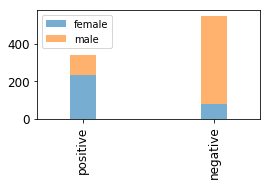

In [567]:
bar_by_feat(train,"Survived","Sex")

It is evident that you are more likely to survive if female.

### Age

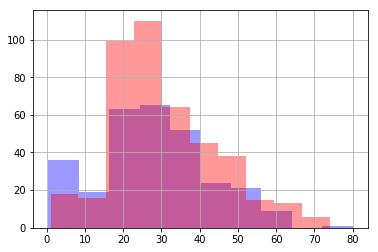

In [568]:
train.loc[train["Survived"]==1,"Age"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"Age"].hist(alpha=0.4,color="red")

It appears being in your mid 20s is not good for your survival chances!

### Fare

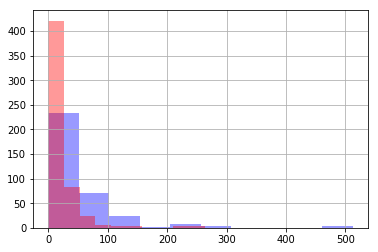

In [569]:
train.loc[train["Survived"]==1,"Fare"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"Fare"].hist(alpha=0.4,color="red")

Clearly the price you pay greatly influences your chance of surivial. At the extreme high prices, you survive.

The fares are clearly positively skewed. I may need to play with that later

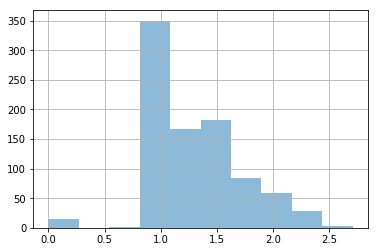

In [570]:
#np.log(train.loc[train["Fare"]!=0.0]).hist(alpha=0.4,color="blue")
#(np.log((train["Fare"]+1))).hist(alpha=0.7)
(np.log10((train["Fare"]+1))).hist(alpha=0.5)
#((train["Fare"])).hist()
#(((train["Fare"])**(1/3))).hist(alpha=0.5)

### Pclass

In [878]:
train["Pclass"].unique()

array([3, 1, 2])

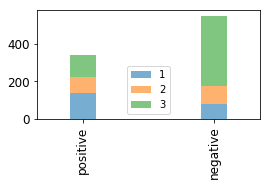

In [879]:
bar_by_feat(train,"Survived","Pclass")

Cearly most passengers are in 3rd class and most will die. 2/3 first class passengers will survive

In [795]:
for pclass in train["Pclass"].unique():
    died=train.loc[(train["Pclass"] ==pclass) & (train["Survived"] == 0), "Pclass"].shape[0]
    diedpcnt=(died/train.loc[train["Pclass"]==pclass].shape[0])*100
    survived=train.loc[(train["Pclass"] ==pclass) & (train["Survived"] == 1), "Pclass"].shape[0]
    survivedpcnt=(survived/train.loc[train["Pclass"]==pclass].shape[0])*100
    print("Class {}: {} ({:.0f}%) Survived, {} ({:.0f}%) Died".format(pclass,survived,survivedpcnt,died,diedpcnt))

Class 3: 119 (24%) Survived, 372 (76%) Died
Class 1: 136 (63%) Survived, 80 (37%) Died
Class 2: 87 (47%) Survived, 97 (53%) Died


In [455]:
def pclass(df):
    pclasses = pd.get_dummies(df['Pclass'], prefix="Pclass")
    df = pd.concat([df,pclasses],axis=1)
    #df.drop('Pclass',axis=1,inplace=True)
    return df

In [456]:
pclasses = pd.get_dummies(train['Pclass'], prefix="Pclass")
train = pd.concat([train,pclasses],axis=1)

### SibSp

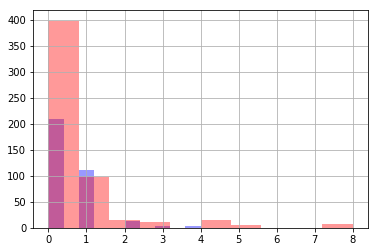

In [576]:
train.loc[train["Survived"]==1,"SibSp"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"SibSp"].hist(alpha=0.4,color="red")

### Parch

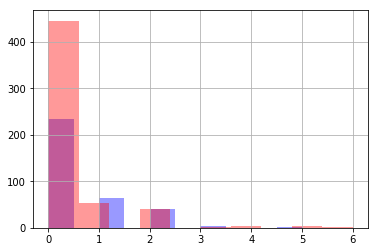

In [577]:
train.loc[train["Survived"]==1,"Parch"].hist(alpha=0.4,color="blue")
train.loc[train["Survived"]==0,"Parch"].hist(alpha=0.4,color="red")

# Conversion of catagorical data

In order to build a classifier, we are going to have to convert our catagorical features (sex,ticket,embarked) to vectors.

## Embarked

In [578]:
for i in train.select_dtypes(include=['object']).columns:
    print("{}: {} values, {} unique".format(i,len(train[i]),len(train[i].unique())))

Name: 891 values, 891 unique
Sex: 891 values, 2 unique
Ticket: 891 values, 681 unique
Cabin: 891 values, 148 unique
Embarked: 891 values, 4 unique


The name, ticket and cabin variables have many values. For my first model, I will exclude these. I shall only include "Sex" and "Embarked" of the catagorical values in the model. For this I will need to convert them to floating point values

In [116]:
train["Embarked"].isnull().sum()

2

In [580]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

First, lets fill in the 2 nans with S, the most common embark point

In [4]:
train["Embarked"].fillna(value="S",inplace=True)

In [5]:
new_embarked=pd.get_dummies(train['Embarked'],prefix='Embarked')

In [6]:
train = pd.concat([train,new_embarked],axis=1)

## Sex

In [1143]:
train["Sex"].unique()

array(['male', 'female'], dtype=object)

In [7]:
train["Sex"]=train["Sex"].replace(to_replace='male',value=0)
train["Sex"]=train["Sex"].replace(to_replace='female',value=1)


I am going to test a few different algorithms, using a subset of the data. I expect these to be underfitted, since I have done litte feature engineering up to this point. Iniitally, I will test a few classifiers using _scikitlearn_ to get a baseline accuracy. I will then do some feature engineering to improve the models. 

# Baseline models

In [794]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
features=["Survived","Sex","Age","SibSp","Parch","Fare","Pclass","Embarked_Q","Embarked_S"]

In [11]:
X=train[features].dropna().drop("Survived",axis=1)
y=train[features].dropna()["Survived"]
print(len(X),len(y))
print(y.mean())

714 714
0.406162464986


So 41% of our input data for the first model have value==1 (ie, they survived). This is fair reflection of the original set, which has a 38% survival rate. For the current train set, if we predict 1 for every instance, we would be correct 40% of the time.

I am going to further split our train data set into a train and test set, so we can test our model properly, since the _test_ set provided by Kaggle does not have an answer we can check so we cannot validate our model against it

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(len(y_train))
print(len(y_test))
print(y_train.mean())
print(y_test.mean())

535
179
0.416822429907
0.374301675978


In [14]:
scores={}

### Gaussian Naive Bayes

The first method I will trial is Gaussian Naive Bayes

In [15]:
gnb = GaussianNB()
gnb=gnb.fit(X_train,y_train)
gnb.score(X_train,y_train)
print(gnb.score(X_train,y_train))

0.783177570093


So GNB is accurate on 78.3% of the training data. What about the test set?

In [16]:
print("GNB accurately predicts {:.2f}% of the test set".format(gnb.score(X_test,y_test)*100))
scores["GNB"]=gnb.score(X_test,y_test)*100

GNB accurately predicts 76.54% of the test set


In [893]:
gnb_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total {} points : {}".format(X_test.shape[0],(y_test != gnb_pred).sum()))

Number of mislabeled points out of a total 179 points : 42


In [895]:
tn, fp, fn, tp = confusion_matrix(y_test,gnb_pred).ravel()
(tn, fp, fn, tp)

(93, 19, 23, 44)

In [896]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 93
Incorrect Survival: 19
Incorrect Death: 23
Correct Surivival: 44


### Logistic Regression

In [17]:
lrmodel=LogisticRegression()
lrmodel=lrmodel.fit(X_train,y_train)
lrmodel.score(X_train,y_train)


0.79065420560747668

In [18]:
lrmodel.score(X_test,y_test)
scores["LR"]=lrmodel.score(X_test,y_test)*100

In [21]:
lr_pred = lrmodel.fit(X_train, y_train).predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,lr_pred).ravel()
(tn, fp, fn, tp)

(98, 14, 23, 44)

In [901]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 98
Incorrect Survival: 14
Incorrect Death: 23
Correct Surivival: 44


### Decision Tree

In [22]:
dt=DecisionTreeClassifier()
dt=dt.fit(X_train,y_train)
dt.score(X_train,y_train)


0.98691588785046724

In [23]:
print(dt.score(X_test,y_test))
scores["DT"]=dt.score(X_test,y_test)*100

0.821229050279


In [24]:
dt_pred = dt.fit(X_train, y_train).predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,dt_pred).ravel()
(tn, fp, fn, tp)

(96, 16, 16, 51)

In [25]:
print("Correct deaths: {}\nIncorrect Survival: {}\nIncorrect Death: {}\nCorrect Surivival: {}".format(tn,fp,fn,tp))

Correct deaths: 96
Incorrect Survival: 16
Incorrect Death: 16
Correct Surivival: 51


In [26]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#### Visualise the decision tree

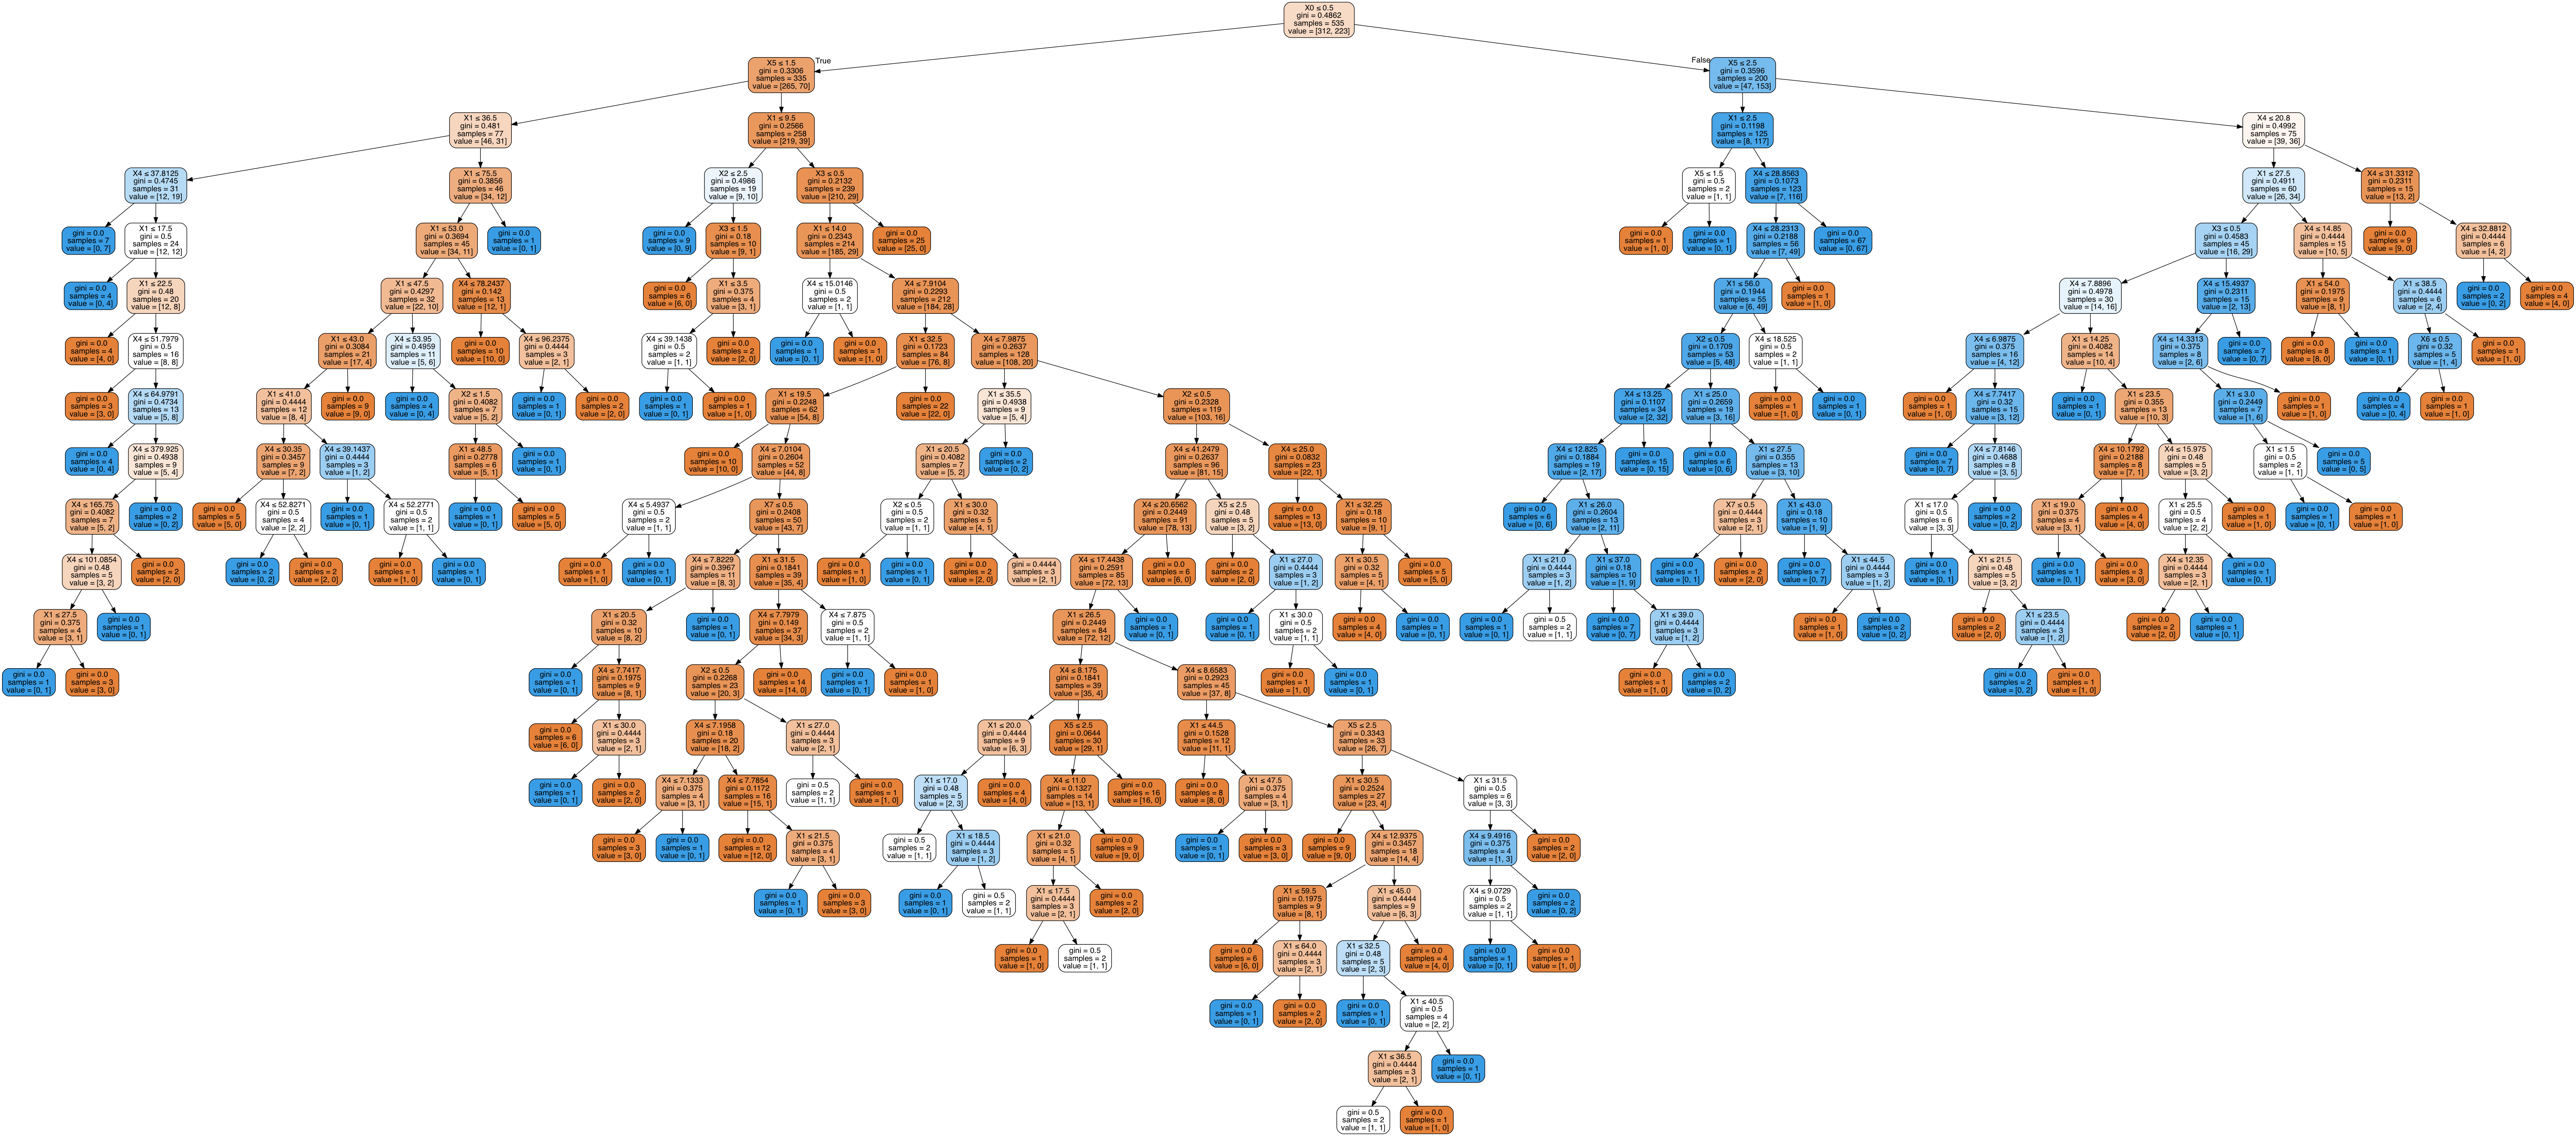

In [27]:
# thanks to https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [28]:
X_train.columns

Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

### Gradient Boosting

Lets see if gradient boosting improves upon the lone decision tree

In [29]:
gb=GradientBoostingClassifier()
gb=gb.fit(X_train,y_train)
gb.score(X_train,y_train)
feature_importance=gb.feature_importances_

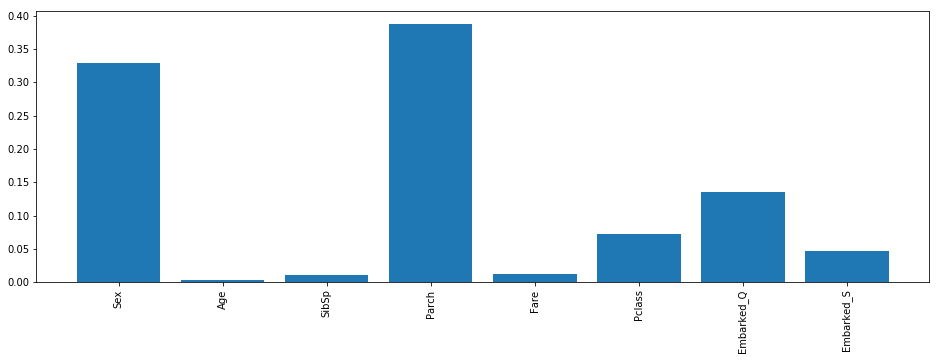

In [30]:
fix,ax=plt.subplots(figsize=(16,5))
_ = ax.bar(X.columns,feature_importance)
_=ax.set_xticklabels(X.columns, rotation=90)

In [31]:
print(gb.score(X_test,y_test))
scores["gb"]=gb.score(X_test,y_test)*100

0.860335195531


### Random Forests

In [32]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_train, y_train)


0.98691588785046724

In [33]:
rf.score(X_test,y_test)

0.81005586592178769

In [34]:
scores["rf"]=rf.score(X_test,y_test)*100

# Summary of baseline models

In [35]:
scores

{'DT': 82.122905027932958,
 'GNB': 76.536312849162016,
 'LR': 79.329608938547494,
 'gb': 86.033519553072622,
 'rf': 81.005586592178773}

# Engineering

## Overview

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Pclass_1       891 non-null uint8
Pclass_2       891 non-null uint8
Pclass_3       891 non-null uint8
Embarked_C     891 non-null uint8
Embarked_Q     891 non-null uint8
Embarked_S     891 non-null uint8
dtypes: float64(2), int64(5), object(3), uint8(6)
memory usage: 74.9+ KB


In [61]:
print("{} in the set, {} features in the training set, {} in the test set. {} features excluded".format(train.shape[0],y_train.shape[0],y_test.shape[0],(train.shape[0]-(y_train.shape[0]+y_test.shape[0]))))

891 in the set, 535 features in the training set, 179 in the test set. 177 features excluded


## Adding an _accompanied_ feature

The first feature I want to work on is whether someone is travelling alone or not. It seems to me that a child's survival chance will be improved if they are travelling with an adult, and vice versa, since we know history (and the movie _Titanic_ ;)) that women and children were evacuated on life boats.

In [121]:
def accompanied(df):
    df["Accompanied"]=df["Parch"]+df["SibSp"]
    df['Accompanied'].loc[df['Accompanied'] > 0] = 1
    df['Accompanied'].loc[df['Accompanied'] == 0] = 0
    return df

In [122]:
train=accompanied(train)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Adding a _Family Size_ Feature

From the SibSp and Parch features, we can determine the size of the family, and how this influences survival 

In [123]:
def FamSize(df):
    df["FamSize"]= df["Parch"] + df["SibSp"] +1 
    return df

In [124]:
train=FamSize(train)

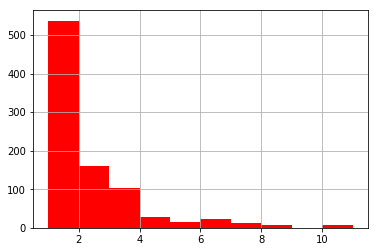

In [619]:
train["FamSize"].hist(color="red")
#train.loc[train["Survived"]==1,"FamSize"].hist(color="blue")
#train.loc[train["Survived"]==0,"FamSize"].hist(color="orange")

## Dealing with _Name_ feature

In [70]:
train["Name"].head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

For the woman, their name is given in brackets, while the name of their husband is assigned after their title. Thus the data structure is for a male name is 

_lastname_, + _title_. + _firstname1_ + _firstname2_ ... 

and for a married female is 

_lastname_, + _title_. + _husbandfirstname1_ + _husbandfirstname2_ ... + _(first middle last)_

For example, in index 1, Mrs Futrelle is married to Jacques, and her first name is Lily and her maiden name is Peel:

In [641]:
train.loc[train["Name"].str.contains("(Futrelle)")]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Accompanied,FamSize,Title
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1,C123,0,0,1,1,2,Mrs
137,138,0,1,"Futrelle, Mr. Jacques Heath",0,37.0,1,0,113803,53.1,C123,0,0,1,1,2,Mr


The _Name_ feature has some useful imformation, most notably the title. This can help us in a number of ways. For example, we can determine if a woman is married and thus deconvolute the _SibSp_ feature. 

Lets check how many different titles we have in our dataset. We can do this using the map function, where we initially split the name using the comma as the delimiter. We can then split after the comma using the full stop as the delimiter to get the title

In [284]:
train['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip()).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

Along with the commonplace _Mr_ and _Mrs_, we have some unusual titles such as _Major_, _Capt_, and _Jonkheer_, which is apparently a Dutch nobility title. First of all, lets create a married column 

In [125]:
train["Title"]=train['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())

In [18]:
train["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [126]:
def married(title):
    MarriedWomanTitles=["Mrs","Lady","Mme","the Countess"]
    if title in MarriedWomanTitles:
        return 1
    else:
        return 0

In [127]:
train["MarriedWoman"]=train["Title"].apply(married)

In [21]:
train["MarriedWoman"].sum()

128

Now lets deal with the special, or noble, titles

In [128]:
def special(title):
    SpecialTitles=['Don','Major','Lady', 'Sir','Col','the Countess','Jonkheer']
    if title in SpecialTitles:
        return 1
    else:
        return 0

In [129]:
train["SpecialTitle"]=train["Title"].apply(special)

In [24]:
train["SpecialTitle"].sum()

9

In [25]:
train=train.drop("Title",axis=1)

In [473]:
train=train.drop("Name",axis=1)

## Dealing with _Cabin_ feature

In [130]:
def cabin(df):
    df["Cabin"]=df["Cabin"].apply(lambda x: str(x)[0])
    new_cabins=pd.get_dummies(df['Cabin'],prefix='Cabin')
    df=pd.concat([df,new_cabins],axis=1)
    #df=df.drop("Cabin",axis=1)
    return df

In [131]:
train=cabin(train)

From this we know two things: firstly, there are lot (687) of unknown cabins. Secondly, the cabin is prefixed with a letter, which we can take is perhaps the floor, or deck number. Lets create variables for each of the decks that we know about. We can also create a "deck unavailable" column, since this is perhaps very important

In [132]:
def cabin2float(cabin):
    if str(cabin)=="A":
        return 0
    elif str(cabin)=="B":
        return 1
    elif str(cabin)=="C":
        return 2
    elif str(cabin)=="D":
        return 3
    elif str(cabin)=="E":
        return 4
    elif str(cabin)=="F":
        return 5
    elif str(cabin)=="G":
        return 6
    elif str(cabin)=="T":
        return 7
    else:
        return 8
    

In [133]:
train["Cabin"]=train["Cabin"].apply(lambda x: cabin2float(x))

In [107]:
train["Cabin"].unique()

array([8, 2, 4, 6, 3, 0, 1, 5, 7])

In [428]:
train.loc[train["Cabin"]=="T"]

,PassengerId,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Accompanied,FamSize,MarriedWoman,SpecialTitle
339,340,0,0,45.0,0,0,113784,35.5,T,1,0,0,0,0,1,0,1,0,0


In [429]:
new_cabins=pd.get_dummies(train['Cabin'],prefix='Cabin')

In [430]:
train=pd.concat([train,new_cabins],axis=1)

In [431]:
train=train.drop("Cabin",axis=1)

In [655]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Accompanied', 'FamSize', 'MarriedWoman', 'SpecialTitle', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Cabin_n'],
      dtype='object')

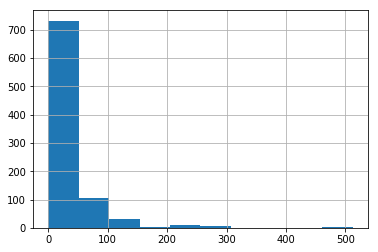

In [327]:
train["Fare"].hist()

In [480]:
train["FareLog"] = train["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

## Filling in missing ages

In [134]:
old_ages=train["Age"]

In [135]:
print("There are {} missing ages.".format(train[train["Age"].isnull()].shape[0]))

There are 177 missing ages.


There are different ways to complete the ages. The easist is probably by just using the median age. However, this brute force approach is not particularly elegant and risks us losing a lot of resultion. Is there a more nuanced approach? For instance, we can train a model to predict the missing ages, using age bins and a classification algorithm

In [108]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Accompanied', 'FamSize', 'MarriedWoman',
       'SpecialTitle', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_n', 'AgeBin'],
      dtype='object')

### Age Assignment

#### Age using linear regression

In [1044]:
age_features=['Survived', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Pclass', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Accompanied', 'FamSize', 'MarriedWoman', 'SpecialTitle',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_n']

In [1045]:
X=train[age_features].dropna().drop("Age",axis=1)
y=train[age_features].dropna()["Age"]
print(len(X),len(y))
print(y.mean())


714 714
29.6991176471


In [1046]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [1047]:
Age_regr = LinearRegression()
Age_regr = Age_regr.fit(X,y)
Age_regr.score(X,y)


0.38764409810387068

In [1048]:
age_pred=Age_regr.predict(X)

In [1049]:
df=pd.DataFrame({"pred": age_pred,"actual":y})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117d8a630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117921710>]], dtype=object)

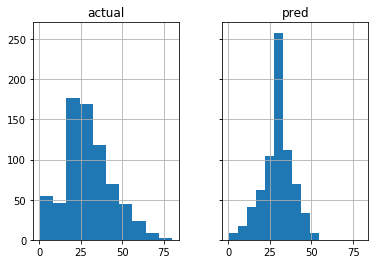

In [1050]:
df.hist(sharex=True,sharey=True)

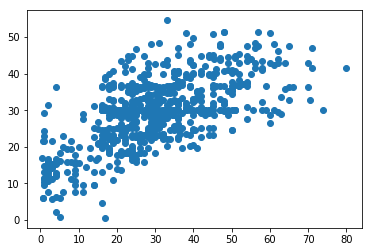

In [1051]:
plt.scatter(y,age_pred)

Evidently, this rudimentary LR model for age prediction is poorly predicting the age data. However, it is still better than a brute fore assignment of the median age.  The biggest problem is that it we are not predicting enough children, or enough people older than 50.

In [1052]:
missing_age_indexes=train['Age'].index[train['Age'].apply(np.isnan)]
missing_age_indexes

Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)

In [1053]:
new_ages=Age_regr.predict(train.loc[missing_age_indexes,age_features].drop("Age",axis=1))

In [1054]:
len(new_ages)

177

(array([  7.,   1.,   4.,   9.,  19.,  21.,  78.,  14.,  17.,   7.]),
 array([ -4.42181086,   1.01128748,   6.44438582,  11.87748415,
         17.31058249,  22.74368083,  28.17677917,  33.6098775 ,
         39.04297584,  44.47607418,  49.90917251]),
 <a list of 10 Patch objects>)

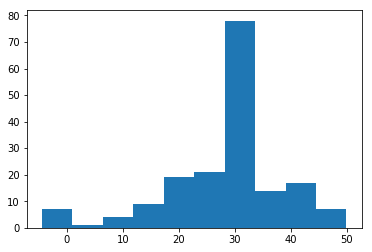

In [1055]:
plt.hist(new_ages)

In [1056]:
[i for i in new_ages if i<0]

[-4.4218108565772525, -4.4218108565772525, -4.4218108565772525]

Here we have a problem in the age prediction, since 3 values are predicted as negative. For now, we can just set these to 0

In [1057]:
train["Age"].loc[missing_age_indexes]=new_ages

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [1058]:
train.loc[train["Age"]<0,"Age"]=0

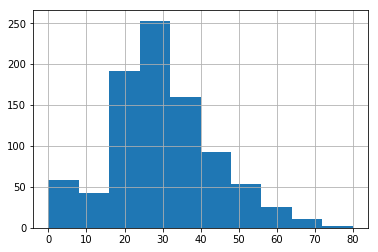

In [1059]:
train["Age"].hist()

Overall, I am not happy with using the linear regression to predict age. I will change tactic and band the ages together and use a classifier instaed

#### Age band using RF

In [136]:
train["AgeBand"]=pd.cut(train["Age"],5)
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.369942
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [33]:
age2band={0:[0.34,16.336],1: [16.336,32.252],2:[32.252, 48.168],3:[48.168, 64.084],4:[64.084, 80.0]}

In [137]:
train.loc[train["Age"]<=16.36,"AgeBin"]=0
train.loc[(train["Age"]>16.36) & (train["Age"]<=32.25),"AgeBin"]=1
train.loc[(train["Age"]>32.25) & (train["Age"]<=48.17),"AgeBin"]=2
train.loc[(train["Age"]>48.17) & (train["Age"]<=64.08),"AgeBin"]=3
train.loc[(train["Age"]>64.08) & (train["Age"]<=80.08),"AgeBin"]=4
train=train.drop("AgeBand",axis=1)

In [138]:
train[['AgeBin', 'Survived']].groupby(['AgeBin'], as_index=False).mean().sort_values(by='AgeBin', ascending=True)

,AgeBin,Survived
0,0.0,0.550000
1,1.0,0.369942
2,2.0,0.404255
3,3.0,0.434783
4,4.0,0.090909


In [139]:
age_features=['Pclass', 'Sex','SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Accompanied', 'FamSize', 'MarriedWoman',
       'SpecialTitle', 'AgeBin']

In [140]:
X=train[age_features].dropna().drop("AgeBin",axis=1)
y=train[age_features].dropna()["AgeBin"]
len(X)

714

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(len(y_train))
print(len(y_test))
print(y_train.mean())
print(y_test.mean())

535
179
1.3738317757
1.32960893855


In [142]:
Age_rf = RandomForestClassifier(n_estimators=100)
Age_rf = Age_rf.fit(X,y)
Age_rf.score(X,y)


0.85434173669467783

In [143]:
age_pred=Age_rf.predict(X)

In [144]:
df=pd.DataFrame({"pred": age_pred,"actual":y})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11064d978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1104965f8>]], dtype=object)

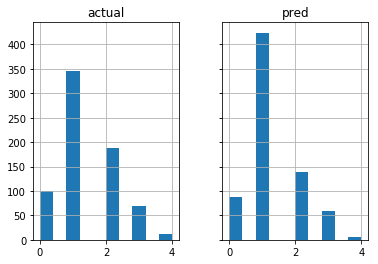

In [145]:
df.hist(sharex=True,sharey=True)

In [146]:
missing_age_indexes=train['Age'].index[train['Age'].apply(np.isnan)]
missing_age_indexes

Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)

In [147]:
new_age_bands=Age_rf.predict(train.loc[missing_age_indexes,age_features].drop("AgeBin",axis=1))

In [148]:
len(new_age_bands)

177

(array([  24.,    0.,  130.,    0.,    0.,   17.,    0.,    4.,    0.,    2.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

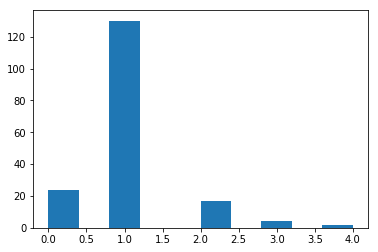

In [149]:
plt.hist(new_age_bands)

In [150]:
def random_age_from_band(data):
    random_ages=[]
    for i in data:
        random_ages.append(np.random.randint(low=age2band[i][0],high=age2band[i][1]))
    return np.array(random_ages)

(array([  9.,  13.,  46.,  56.,  33.,   7.,   7.,   1.,   3.,   2.]),
 array([  0. ,   6.9,  13.8,  20.7,  27.6,  34.5,  41.4,  48.3,  55.2,
         62.1,  69. ]),
 <a list of 10 Patch objects>)

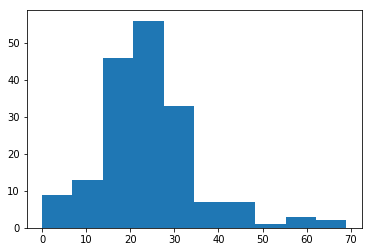

In [151]:
new_ages=random_age_from_band(new_age_bands)
plt.hist(random_age_from_band(new_age_bands))

In [152]:
train["AgeBin"].loc[missing_age_indexes]=new_age_bands

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [153]:
train["Age"].loc[missing_age_indexes]=new_ages

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


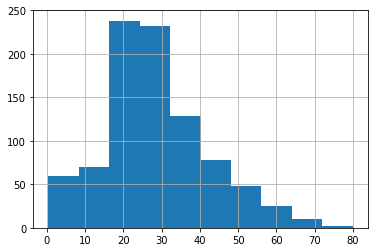

In [52]:
train["Age"].hist()

# Remodel Data

## Set up

In [154]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,...,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_n,AgeBin
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,28.566970,0.523008,0.381594,32.204208,6.716049,0.188552,...,0.016835,0.052750,0.066218,0.037037,0.035915,0.014590,0.004489,0.001122,0.771044,1.298541
std,257.353842,0.486592,0.836071,0.477990,14.102974,1.102743,0.806057,49.693429,2.460739,0.391372,...,0.128725,0.223659,0.248802,0.188959,0.186182,0.119973,0.066890,0.033501,0.420397,0.860225
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.000000,0.000000,0.000000,7.910400,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,446.000000,0.000000,3.000000,0.000000,27.000000,0.000000,0.000000,14.454200,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,31.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,8.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [155]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Accompanied', 'FamSize', 'Title',
       'MarriedWoman', 'SpecialTitle', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_n',
       'AgeBin'],
      dtype='object')

In [156]:
features=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Accompanied', 'FamSize', 'MarriedWoman', 'SpecialTitle']

In [157]:
X=train[features].dropna().drop("Survived",axis=1)
y=train[features].dropna()["Survived"]
print(len(X),len(y))
print(y.mean())

891 891
0.383838383838


In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(len(y_train))
print(len(y_test))
print(y_train.mean())
print(y_test.mean())

668
223
0.369760479042
0.42600896861


## Random Forest

In [553]:
rf=RandomForestClassifier()
rf=rf.fit(X_train,y_train)
rf.score(X_train,y_train)

0.97754491017964074

In [554]:
rf.score(X_test,y_test)

0.76681614349775784

## Gradient Boost

In [159]:
gb=GradientBoostingClassifier()
gb=gb.fit(X_train,y_train)
gb.score(X_train,y_train)

0.91766467065868262

In [160]:
gb.score(X_test,y_test)

0.7847533632286996

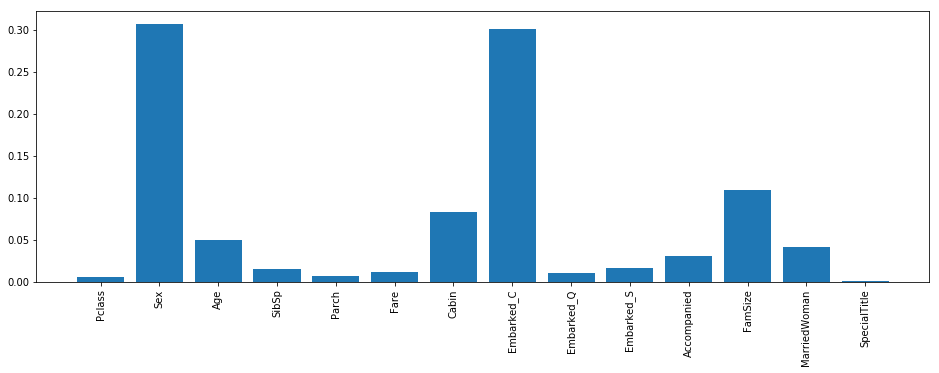

In [161]:
fix,ax=plt.subplots(figsize=(16,5))
_ = ax.bar(X.columns,gb.feature_importances_)
_=ax.set_xticklabels(X.columns, rotation=90)

## Support Vector Machine

In [262]:
svc=SVC()
svc=svc.fit(X_train, y_train)
svc.score(X_train, y_train)

0.86377245508982037

In [263]:
svc.score(X_test, y_test)

0.68609865470852016

## Logistic Regression

In [369]:
lr= LogisticRegression()
lr=lr.fit(X_train,y_train)
lr.score(X_train,y_train)
#lr.coef_


0.80988023952095811

In [370]:
lr.score(X_test,y_test)

0.7982062780269058

## Decision Tree

In [371]:
dt=DecisionTreeClassifier()
dt=dt.fit(X_train,y_train)
dt.score(X_train,y_train)

0.99550898203592819

In [372]:
dt.score(X_test,y_test)

0.76681614349775784

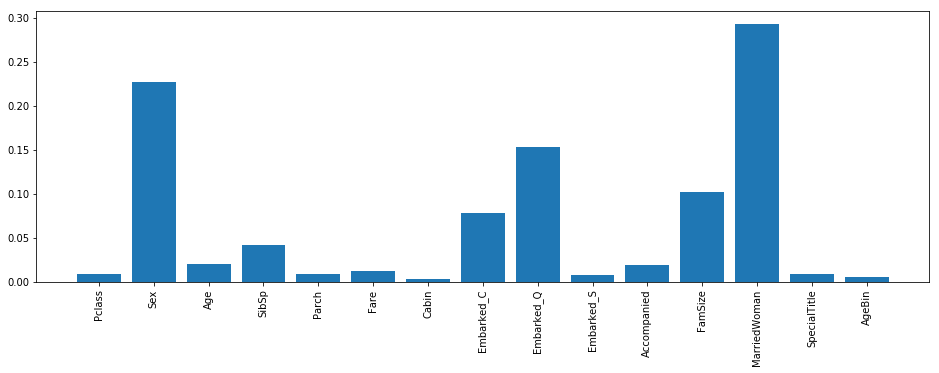

In [373]:
fix,ax=plt.subplots(figsize=(16,5))
_ = ax.bar(X.columns,dt.feature_importances_)
_=ax.set_xticklabels(X.columns, rotation=90)

# Test Data

In [86]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 29 columns):
PassengerId     418 non-null int64
Pclass          418 non-null int64
Name            418 non-null object
Sex             418 non-null int64
Age             418 non-null float64
SibSp           418 non-null int64
Parch           418 non-null int64
Ticket          418 non-null object
Fare            418 non-null float64
Cabin           418 non-null int64
Embarked        418 non-null object
Title           418 non-null object
MarriedWoman    418 non-null int64
SpecialTitle    418 non-null int64
Embarked_C      418 non-null uint8
Embarked_Q      418 non-null uint8
Embarked_S      418 non-null uint8
Cabin_A         418 non-null uint8
Cabin_B         418 non-null uint8
Cabin_C         418 non-null uint8
Cabin_D         418 non-null uint8
Cabin_E         418 non-null uint8
Cabin_F         418 non-null uint8
Cabin_G         418 non-null uint8
Cabin_n         418 non-null uint8
Accompanied 

In [93]:
features

['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Cabin',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Accompanied',
 'FamSize',
 'MarriedWoman',
 'SpecialTitle']

## Prepare features

### Name

In [162]:
test["Title"]=test['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
test["MarriedWoman"]=test["Title"].apply(married)
test["SpecialTitle"]=test["Title"].apply(special)

### Sex

In [163]:
test["Sex"]=test["Sex"].replace(to_replace='male',value=0)
test["Sex"]=test["Sex"].replace(to_replace='female',value=1)

### Embarked

In [164]:
new_embarked=pd.get_dummies(test['Embarked'],prefix='Embarked')
test = pd.concat([test,new_embarked],axis=1)

### Cabin

In [165]:
test=cabin(test)

In [166]:
test["Cabin"]=test["Cabin"].apply(lambda x: cabin2float(x))

### Accompanied

In [167]:
test=accompanied(test)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### FamSize

In [168]:
test=FamSize(test)

### Age

In [169]:
test["AgeBand"]=pd.cut(old_ages,5)

In [170]:
test.loc[test["Age"]<=16.36,"AgeBin"]=0
test.loc[(test["Age"]>16.36) & (test["Age"]<=32.25),"AgeBin"]=1
test.loc[(test["Age"]>32.25) & (test["Age"]<=48.17),"AgeBin"]=2
test.loc[(test["Age"]>48.17) & (test["Age"]<=64.08),"AgeBin"]=3
test.loc[(test["Age"]>64.08) & (test["Age"]<=80.08),"AgeBin"]=4

In [171]:
age_pred=Age_rf.predict(test[age_features].dropna().drop("AgeBin",axis=1))

In [172]:
missing_age_indexes=test['Age'].index[test['Age'].apply(np.isnan)]
new_age_bands=Age_rf.predict(test.loc[missing_age_indexes,age_features].drop("AgeBin",axis=1))
new_ages=random_age_from_band(new_age_bands)
test["AgeBin"].loc[missing_age_indexes]=new_age_bands
test["Age"].loc[missing_age_indexes]=new_ages

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [173]:
test["Age"].isnull().any()

False

### Fare

In [174]:
test["Fare"].fillna(train["Fare"].median(),inplace=True)

In [175]:
test["Fare"].isnull().any()

False

## Apply GB to test set

In [176]:
test_features=[i for i in features if i!="Survived"]

In [177]:
test[test_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
Pclass          418 non-null int64
Sex             418 non-null int64
Age             418 non-null float64
SibSp           418 non-null int64
Parch           418 non-null int64
Fare            418 non-null float64
Cabin           418 non-null int64
Embarked_C      418 non-null uint8
Embarked_Q      418 non-null uint8
Embarked_S      418 non-null uint8
Accompanied     418 non-null int64
FamSize         418 non-null int64
MarriedWoman    418 non-null int64
SpecialTitle    418 non-null int64
dtypes: float64(2), int64(9), uint8(3)
memory usage: 37.2 KB


In [178]:
test_pred=gb.predict(test[test_features])

In [179]:
submit=pd.DataFrame({"PassengerId":test["PassengerId"],"Survived":test_pred})

So there we have it - our predictions have been made! 

Thanks for reading

md